In [1]:
!nvidia-smi

Tue Jul 23 04:32:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# import os
# print(os.listdir("../input"))

In [4]:
%%capture
!pip install datasets
!pip install transformers
!pip install rouge_score
!pip install evaluate

# **Load Data**

In [6]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='../input/dataset-risalah/train.json')['train']
val_dataset = load_dataset('json', data_files='../input/dataset-risalah/validation.json')['train']


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
train_dataset

Dataset({
    features: ['risalah_text', 'tanggal', 'summary_text', 'url risalah', 'judul rapat', 'nama file', 'word_count', 'id'],
    num_rows: 80
})

In [8]:
val_dataset

Dataset({
    features: ['risalah_text', 'tanggal', 'summary_text', 'url risalah', 'judul rapat', 'nama file', 'word_count', 'id'],
    num_rows: 10
})

In [9]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=2):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [10]:
# show_random_elements(dataset["train"])

# **If Using Praproses**
### prarposes dengan lowercase + hapus tanda baca dan spesial karakter

In [ ]:
import re
def text_cleaner(text):
    # lower
    newString = text.lower()
    # Eliminate punctuations and special characters, replacing them with a space
    newString = re.sub(r'[^\w\s]', ' ', newString)
    # Remove extra spaces
    newString = re.sub(r'\s+', ' ', newString).strip()
    return newString

def clean_text_column(data, column_name):
    data[column_name] = text_cleaner(data[column_name])
    return data

In [ ]:
# Clean the training dataset
train_dataset = train_dataset.map(lambda example: clean_text_column(example, 'risalah_text'))
train_dataset = train_dataset.map(lambda example: clean_text_column(example, 'summary_text'))

# Clean the validation dataset
val_dataset = val_dataset.map(lambda example: clean_text_column(example, 'risalah_text'))
val_dataset = val_dataset.map(lambda example: clean_text_column(example, 'summary_text'))


In [ ]:
val_dataset['summary_text'][5]

# **Tokenizing**

In [11]:
from transformers import AutoTokenizer

In [12]:
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [13]:
# print(tokenizer.model_max_length)

In [14]:
max_input_length = 16384
max_output_length = 1024
batch_size = 1

In [15]:
def process_data_to_model_inputs(batch):
    
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["risalah_text"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )
    outputs = tokenizer(
        batch["summary_text"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # create 0 global_attention_mask lists
     # buat setiap awal sequence dalam batch memiliki 0 sepanjang fixed length input ids
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    # mengubah token PAD menjadi -100 agar diabaikan
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch

In [16]:
val_dataset

Dataset({
    features: ['risalah_text', 'tanggal', 'summary_text', 'url risalah', 'judul rapat', 'nama file', 'word_count', 'id'],
    num_rows: 10
})

In [17]:
train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["risalah_text", "summary_text"],
)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [18]:
val_dataset =  val_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["risalah_text", "summary_text"]
)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [19]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

In [20]:
from transformers import AutoModelForSeq2SeqLM

In [22]:
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", use_cache=False)

pytorch_model.bin:   0%|          | 0.00/648M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
# from transformers import LongformerConfig, LongformerModel

# # Initializing a Longformer configuration
# configuration = LongformerConfig(hidden_dropout_prob=0.05)

# # Initializing a model from the configuration
# led = LongformerModel(configuration)

# # Accessing the model configuration



In [23]:
# set hyperparameters
led.config.num_beams = 2
led.config.max_length = 1024
led.config.min_length = 128
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3
led.config.dropout = 0.2
led.config.hidden_dropout_prob = 0.2
led.config.attention_probs_dropout_prob = 0.2

In [24]:
configuration = led.config
configuration

LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.2,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.2,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_dropout_prob": 0.2,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "length_penalty": 2.0,

# **Evaluation Metric**

In [ ]:
# rouge = load_metric("rouge")

In [25]:
!pip install rouge_score
!pip install nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
import nltk

nltk.download("punkt")

import evaluate

rouge_score = evaluate.load("rouge")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2024-07-23 04:34:58.739703: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 04:34:58.739823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 04:34:58.869595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [27]:
# def compute_metrics(pred):
#     labels_ids = pred.label_ids
#     pred_ids = pred.predictions

#     pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
#     labels_ids[labels_ids == -100] = tokenizer.pad_token_id
#     label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

#     rouge_output = rouge.compute(
#         predictions=pred_str, references=label_str, rouge_types=["rouge1"]
#     )["rouge1"].mid

#     return {
#         "rouge1_precision": round(rouge_output.precision, 4),
#         "rouge1_recall": round(rouge_output.recall, 4),
#         "rouge1_fmeasure": round(rouge_output.fmeasure, 4),
#     }


from nltk.tokenize import sent_tokenize
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [28]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [34]:

model_name = "led"

args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    output_dir="exp2-led-risalah_data_v6",
    logging_steps=10,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10,
    learning_rate=2e-5,
    warmup_steps=200,
    weight_decay=0.01,
    gradient_checkpointing=True,
    push_to_hub=True,
)


In [30]:
from huggingface_hub import notebook_login

notebook_login()


In [35]:
trainer = Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
trainer.train()

In [ ]:
# lihat history log 
import pandas as pd
pd.DataFrame(trainer.state.log_history)

In [36]:
# evaluasi model hasil train
trainer.evaluate()

{'eval_loss': 1.7589483261108398,
 'eval_rouge1': 26.7539,
 'eval_rouge2': 14.0212,
 'eval_rougeL': 20.1731,
 'eval_rougeLsum': 25.1551,
 'eval_runtime': 87.6507,
 'eval_samples_per_second': 0.114,
 'eval_steps_per_second': 0.114,
 'epoch': 30.0}

In [37]:
# push model ke huggingface
trainer.push_to_hub(commit_message="Training complete", tags="summarization")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'min_length': 128, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


events.out.tfevents.1721696514.d1ca11d71c54.143.0:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

events.out.tfevents.1721703720.d1ca11d71c54.143.1:   0%|          | 0.00/562 [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/silmi224/exp2-led-risalah_data_v5/commit/1e4f7bc10fb6ac47761dfea1ca196620015afcb4', commit_message='Training complete', commit_description='', oid='1e4f7bc10fb6ac47761dfea1ca196620015afcb4', pr_url=None, pr_revision=None, pr_num=None)

In [37]:
# untuk download hasil checkpoint
import shutil
shutil.make_archive('checkpoint-led-v6', 'zip', '/kaggle/working/exp2-led-risalah_data_v6/checkpoint-30')


'/kaggle/working/checkpoint-led-v6.zip'

In [40]:
ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


checkpoint-led-v6.zip  exp2-led-risalah_data_v6/  wandb/


In [41]:
from IPython.display import FileLink

zip_file_path = 'checkpoint-led-v6.zip'

# buat download link
display(FileLink(zip_file_path))

/kaggle/working/checkpoint-led-v6.zip

# **Resume Training from Checkpoint**

### get checkpoint file from drive

In [ ]:
%%capture
!pip install gdown

In [ ]:
import gdown

file_id = '1lHx4Mhrd7sWlU2XTPtt3YeM-5HH6btDk'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'checkpoint-390.zip', quiet=False)


In [ ]:
import os 
os.makedirs('/kaggle/working/checkpoint-led-390')

In [ ]:
! unzip '/kaggle/working/checkpoint-390.zip' -d '/kaggle/working/checkpoint-led-390'

In [ ]:
import os

# List the contents of the /kaggle/working/ directory
contents = os.listdir('/kaggle/working/')
contents


### load model from last checkpoint

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments

last_checkpoint = '/kaggle/working/checkpoint-led-390'

led = AutoModelForSeq2SeqLM.from_pretrained(last_checkpoint)

In [ ]:
# set hyperparameters
led.config.num_beams = 2
led.config.max_length = 1024
led.config.min_length = 128
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3
led.config.dropout = 0.2
led.config.hidden_dropout_prob = 0.2
led.config.attention_probs_dropout_prob = 0.2

In [ ]:
configuration = led.config
configuration

In [ ]:
args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    output_dir="exp2-led-risalah_data_v6",
    logging_steps=10,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=30,
    learning_rate=2e-5,
    warmup_steps=200,
    weight_decay=0.01,
    gradient_checkpointing=True,
    push_to_hub=True,
)


In [ ]:
import transformers
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

transformers.logging.set_verbosity_info()

In [ ]:
trainer.train(last_checkpoint)

In [ ]:
trainer.evaluate()

In [ ]:
trainer.push_to_hub(commit_message="Training complete", tags="summarization")

In [ ]:
import pandas as pd
data = pd.DataFrame(trainer.state.log_history)

# **Plot model loss**

In [ ]:
df = pd.DataFrame(data)

# Filter rows for every 1 epoch (i.e., rows where epoch is an integer)
epoch_data = df[df['epoch'] == df['epoch'].astype(int)]

# Filter out NaN values from 'loss' and 'eval_loss'
train_loss_clean = epoch_data['loss'].dropna()
eval_loss_clean = epoch_data['eval_loss'].dropna()

# Plot the cleaned data
pyplot.plot(train_loss_clean.values, label='train')
pyplot.plot(eval_loss_clean.values, label='test')
pyplot.legend()
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.title('Training and Evaluation Loss')
pyplot.show()

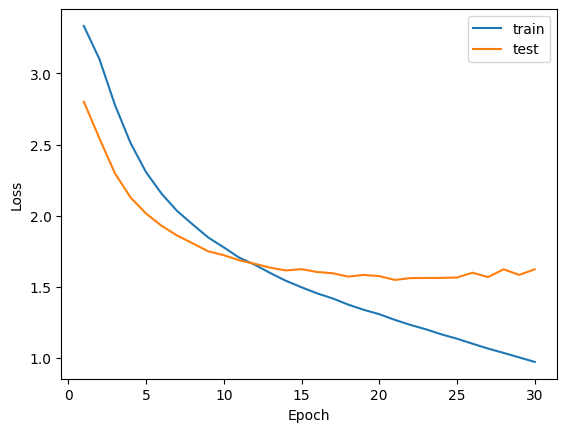

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating the DataFrame with the provided data
data = {
    'Training Loss': [3.3339, 3.1015, 2.779, 2.5118, 2.3057, 2.1541, 2.0326, 1.938, 1.8462, 1.7767, 
                      1.7042, 1.6543, 1.5958, 1.5414, 1.496, 1.4534, 1.4177, 1.3742, 1.3378, 1.3068, 
                      1.2669, 1.2315, 1.2005, 1.1649, 1.1344, 1.099, 1.065, 1.0344, 1.0029, 0.9711],
    'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
              21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    'Step': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 
             170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300],
    'Validation Loss': [2.801, 2.5436, 2.2976, 2.1282, 2.0147, 1.9283, 1.8601, 1.805, 1.7492, 1.7214, 
                        1.6857, 1.661, 1.6335, 1.6145, 1.6234, 1.6035, 1.5948, 1.5712, 1.5829, 1.5746, 
                        1.5476, 1.5606, 1.5617, 1.5618, 1.5649, 1.5985, 1.5678, 1.6225, 1.5831, 1.6223]
}

df = pd.DataFrame(data)

# Plotting the Training and Validation Loss
plt.plot(df['Epoch'], df['Training Loss'], label='train')
plt.plot(df['Epoch'], df['Validation Loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
plt.legend()
plt.show()
